Found 7442 valid audio files.
X_train shape: (4762, 128, 128, 1), y_train shape: (4762,)
X_val shape: (1191, 128, 128, 1), y_val shape: (1191,)
X_test shape: (1489, 128, 128, 1), y_test shape: (1489,)
Class distribution: Counter({4: 814, 1: 814, 3: 813, 0: 813, 2: 813, 5: 695})


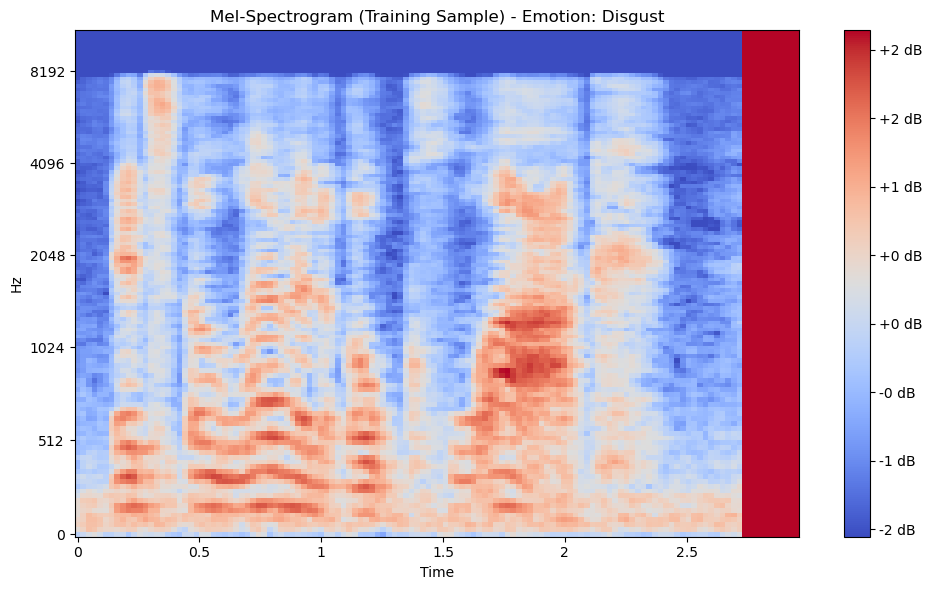

Training samples: 4762, Validation samples: 1191, Test samples: 1489
Class distribution: Counter({4: 814, 1: 814, 3: 813, 0: 813, 2: 813, 5: 695})
Model loaded from CNN/cnn_model.pth


C:\Users\Asus\AppData\Local\Temp\ipykernel_10632\1206219793.py:332: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CNN_MODEL_SAVE_PATH, map_l

Test Loss: 0.8979, Test Accuracy: 0.4359
Confusion Matrix:
[[ 92   9  82  10  20  41]
 [ 10 168   5   4  36  31]
 [ 37   0 200   1  11   5]
 [ 35  85  44  13  40  38]
 [ 37  51  39   5  90  32]
 [ 26  50   7   5  44  86]]
Per-Class Accuracy: {'Class 0 (Happy)': 0.36220472440944884, 'Class 1 (Sad)': 0.6614173228346457, 'Class 2 (Angry)': 0.7874015748031497, 'Class 3 (Fearful)': 0.050980392156862744, 'Class 4 (Disgust)': 0.3543307086614173, 'Class 5 (Neutral)': 0.3944954128440367}
Predicted emotion: Angry


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import re

# Constants
SAMPLE_RATE = 22050
CNN_MODEL_SAVE_PATH = "CNN/cnn_model.pth"
NUM_EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
os.makedirs(os.path.dirname(CNN_MODEL_SAVE_PATH), exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CREMA-D emotion mapping
emotion_map = {'HAP': 0, 'SAD': 1, 'ANG': 2, 'FEA': 3, 'DIS': 4, 'NEU': 5}
label_to_emotion = {0: "Happy", 1: "Sad", 2: "Angry", 3: "Fearful", 4: "Disgust", 5: "Neutral"}

# Custom Audio Augmentations
def add_gaussian_noise(audio, amplitude=0.015):
    if np.random.rand() < 0.5:
        noise = np.random.normal(0, amplitude, len(audio))
        return audio + noise
    return audio

def pitch_shift(audio, sr, n_steps):
    if np.random.rand() < 0.5:
        return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
    return audio

def time_stretch(audio, rate):
    if np.random.rand() < 0.5:
        return librosa.effects.time_stretch(audio, rate=rate)
    return audio

def apply_augmentations(audio, sr):
    audio = add_gaussian_noise(audio, amplitude=np.random.uniform(0.005, 0.015))
    audio = pitch_shift(audio, sr, n_steps=np.random.uniform(-4, 4))
    audio = time_stretch(audio, rate=np.random.uniform(0.8, 1.2))
    return audio

# Feature Extraction with Normalization
def extract_features(file_path, augment=True):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        if len(y) < 0.5 * sr:  # Skip clips <0.5s
            print(f"Skipping {file_path}: Too short")
            return None
        if augment:
            y = apply_augmentations(y, sr)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel = mel_spectrogram_db.T
        if mel.shape[0] > 128:
            mel = mel[:128, :]
        elif mel.shape[0] < 128:
            mel = np.pad(mel, ((0, 128 - mel.shape[0]), (0, 0)), mode='constant')
        # Normalize
        mel = (mel - mel.mean()) / (mel.std() + 1e-8)
        return mel
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Plot Mel-Spectrogram
def plot_mel_spectrogram(mel, label, sr=SAMPLE_RATE, title="Mel-Spectrogram"):
    plt.figure(figsize=(10, 6))
    mel_display = mel.T
    librosa.display.specshow(mel_display, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'{title} - Emotion: {label_to_emotion[label]}')
    plt.tight_layout()
    plt.show()

# Extract Features and Labels from CREMA-D
def load_crema_d(dataset_dir):
    file_paths = []
    labels = []
    for file_name in os.listdir(dataset_dir):
        if file_name.endswith('.wav'):
            file_path = os.path.join(dataset_dir, file_name)
            # Extract emotion (third field, e.g., ANG in 1001_DFA_ANG_XX.wav)
            match = re.search(r'_([A-Z]{3})_(?:[A-Z]{2}|X)\.wav$', file_name)
            if match:
                emotion = match.group(1)
                if emotion in emotion_map:
                    file_paths.append(file_path)
                    labels.append(emotion_map[emotion])
                else:
                    print(f"Unknown emotion {emotion} in {file_name}")
            else:
                print(f"Invalid filename format: {file_name}")
    
    # Check if any valid files were found
    if not file_paths:
        raise ValueError("No valid audio files found in the dataset directory.")
    
    print(f"Found {len(file_paths)} valid audio files.")
    
    # Split into train and test
    train_files, test_files, y_train, y_test = train_test_split(
        file_paths, labels, test_size=0.2, stratify=labels, random_state=42
    )
    
    # Extract features
    def extract_X_y(files, labels, augment=True):
        X = []
        y = []
        for file_path, label in zip(files, labels):
            features = extract_features(file_path, augment=augment)
            if features is not None:
                X.append(features)
                y.append(label)
            else:
                print(f"Skipping {file_path}")
        return np.array(X), np.array(y)
    
    X_train, y_train = extract_X_y(train_files, y_train, augment=True)
    X_test, y_test = extract_X_y(test_files, y_test, augment=False)
    
    # Reshape for CNN
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    
    return X_train, y_train, X_test, y_test

# Load CREMA-D dataset
dataset_dir = "audio-emotion-dataset"  # Adjust to your CREMA-D directory
X_train, y_train, X_test, y_test = load_crema_d(dataset_dir)

# Create validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Verify data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print("Class distribution:", Counter(y_train))

# Plot a sample Mel-spectrogram from X_train
if len(X_train) > 0:
    sample_idx = 0
    mel_sample = X_train[sample_idx].squeeze(-1)
    plot_mel_spectrogram(mel_sample, y_train[sample_idx], title="Mel-Spectrogram (Training Sample)")

# CNN Model with Global Average Pooling
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 256)
        self.dropout = nn.Dropout(0.85)
        self.fc2 = nn.Linear(256, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        if self.training:
            x = self.dropout(x)
        x = self.fc2(x)
        return x

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

# Initialize Model, Loss, Optimizer
model = AudioCNN().to(device)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = FocalLoss(gamma=2.0, alpha=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=2e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# Create tensors and DataLoaders
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

assert y_test_tensor.min() >= 0 and y_test_tensor.max() <= 5, "Invalid test labels"

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")
print("Class distribution:", Counter(y_train))

# Training Function
def train_cnn():
    best_val_loss = float('inf')
    patience = 10
    counter = 0
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 3, 1, 2)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            running_loss += loss.item() * inputs.size(0)
        
        train_loss = running_loss / total_samples
        train_accuracy = correct_predictions / total_samples
        
        # Validation
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.permute(0, 3, 1, 2)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
            val_loss = val_loss / val_total
            val_accuracy = val_correct / val_total
        
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        scheduler.step()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), CNN_MODEL_SAVE_PATH)
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break

# Evaluation Function
def evaluate_cnn():
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 3, 1, 2)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_samples += labels.size(0)
    
    test_loss = test_loss / total_samples
    test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    cm = confusion_matrix(all_labels, all_preds)
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Per-Class Accuracy:", {f"Class {i} ({label_to_emotion[i]})": acc for i, acc in enumerate(per_class_accuracy)})

# Real-World Prediction
def predict_emotion(file_path):
    model.eval()
    mel = extract_features(file_path, augment=False)
    if mel is None:
        return None
    mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    mel = mel.to(device).permute(0, 3, 1, 2)
    with torch.no_grad():
        output = model(mel)
        _, predicted = torch.max(output, 1)
    return label_to_emotion[predicted.item()]

# Load Model
def load_cnn_model():
    try:
        if os.path.exists(CNN_MODEL_SAVE_PATH):
            model.load_state_dict(torch.load(CNN_MODEL_SAVE_PATH, map_location=device))
            model.to(device)
            print(f"Model loaded from {CNN_MODEL_SAVE_PATH}")
        else:
            print(f"No saved model found at {CNN_MODEL_SAVE_PATH}")
    except RuntimeError as e:
        print(f"Error loading model: {e}. Training a new model.")
        raise
    return model

# Main Execution
try:
    if os.path.exists(CNN_MODEL_SAVE_PATH):
        model = load_cnn_model()
        evaluate_cnn()
    else:
        train_cnn()
        evaluate_cnn()
except RuntimeError:
    print("Incompatible checkpoint detected. Training a new model.")
    os.rename(CNN_MODEL_SAVE_PATH, CNN_MODEL_SAVE_PATH + ".backup")
    train_cnn()
    evaluate_cnn()

# Test on a sample
sample_file = "audio-emotion-dataset/1001_DFA_ANG_XX.wav"
print(f"Predicted emotion: {predict_emotion(sample_file)}")